### Approximate distributions for counting stations

Look at the distributions of counts for different seasons, stations, etc.

In [274]:
from data_io.loader.data_loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [275]:
dl = DataLoader()

In [276]:
station = "Plöck"
interval_summer = ("2022-04-01", "2022-07-01")
interval_winter = ("2021-11-01", "2022-02-01")

In [277]:
def get_channel_values(station_name, channel="channels_all", interval=None):
    bike_station_data = dl.get_bicycle(station_name=station_name, interval=interval)
    bike_df = bike_station_data.df
    return bike_df[channel]

### Calculate CDF

In [278]:
def calc_empirical_cdf_with_dkw(station_name, channel = "channels_all", alpha = 0.05, interval = None):
  bike_df = get_channel_values(station_name=station_name, channel=channel, interval=interval)
  x = np.sort(bike_df)
  y = np.arange(1, len(x) + 1) / len(x)
  n = len(x)

  eps = np.sqrt(np.log(2 / alpha) / (2 * n))
  lower = np.clip(y - eps, 0, 1)
  upper = np.clip(y + eps, 0, 1)


  return x, y, lower, upper, eps

x, y, lower, upper, eps = calc_empirical_cdf_with_dkw(station, interval=interval_summer)

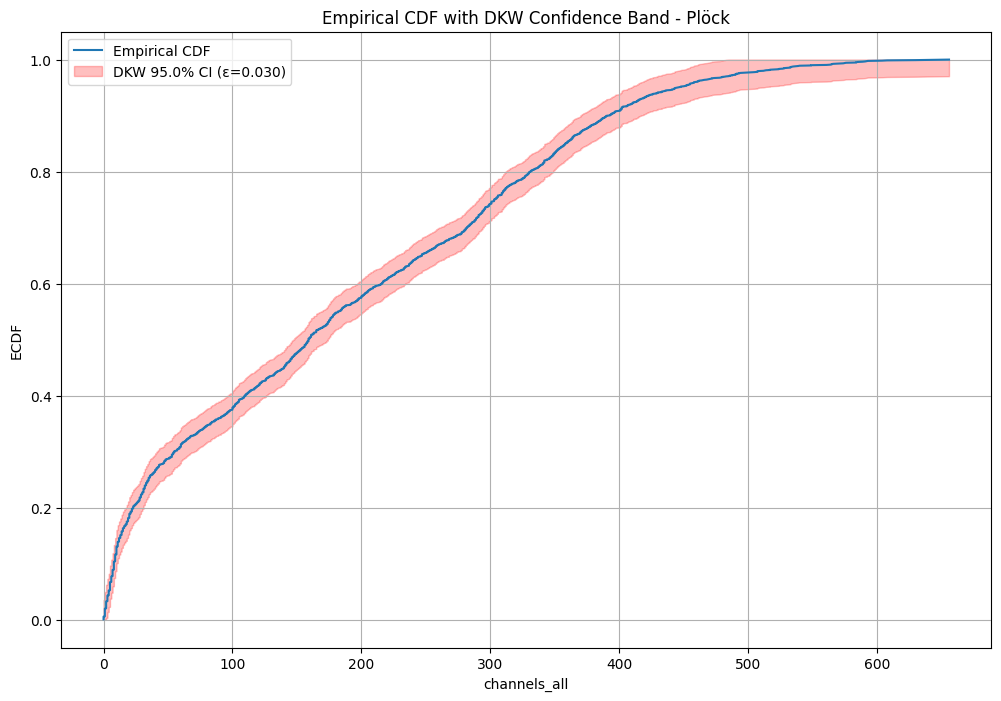

In [279]:
def plot_empirical_cdf_with_dkw(station_name, channel= "channels_all", alpha = 0.05, plot_alpha = 0.25, fig_size = (12,8), interval = None, color_ci = "red"):
  plt.figure(figsize=fig_size)
  plt.plot(x, y, label='Empirical CDF')
  plt.fill_between(x, lower, upper, color=color_ci, alpha=plot_alpha, label=f'DKW {100 - 100 * alpha}% CI (ε={eps:.3f})')
  plt.xlabel(channel)
  plt.ylabel('ECDF')
  plt.title(f'Empirical CDF with DKW Confidence Band - {station_name}')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_empirical_cdf_with_dkw(station)

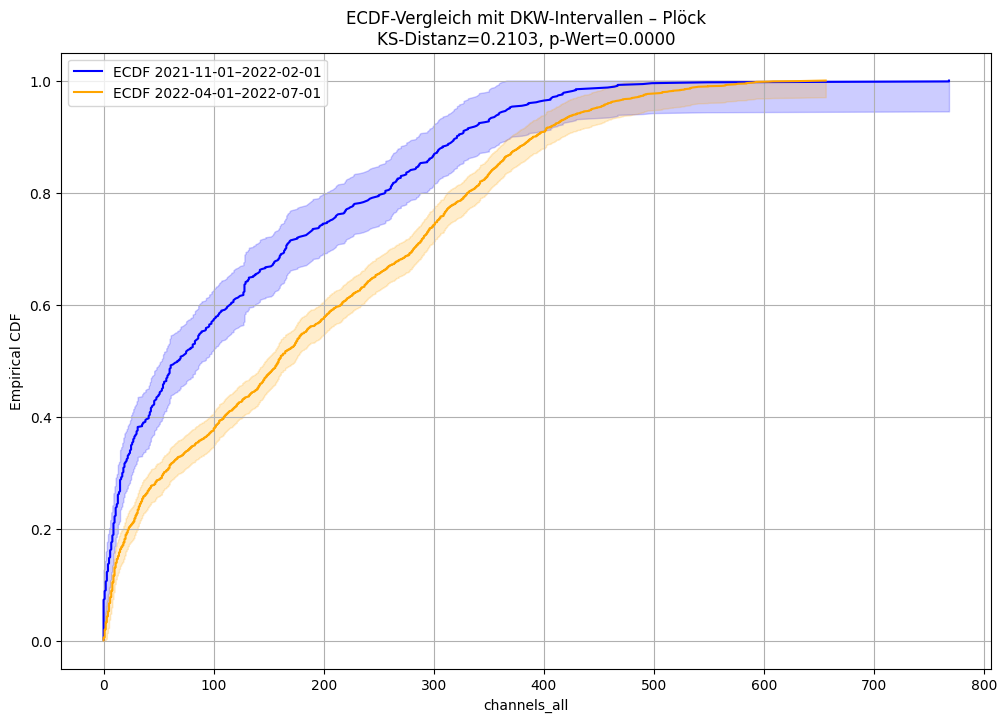

(np.float64(0.21029377516052833), np.float64(1.352427067572527e-19))

In [280]:
from scipy.stats import ks_2samp

def compare_empirical_cdfs_with_dkw(station_name, channel="channels_all", alpha=0.05,  interval1=("2021-11-01", "2022-02-01"), interval2=("2022-04-01", "2022-07-01"), fig_size=(12, 8)):
  x1, y1, lower1, upper1, _ = calc_empirical_cdf_with_dkw(station_name, channel, alpha, interval1)
  x2, y2, lower2, upper2, _ = calc_empirical_cdf_with_dkw(station_name, channel, alpha, interval2)

  raw1 = get_channel_values(station_name, channel, interval1)
  raw2 = get_channel_values(station_name, channel, interval2)
  # KS test
  stat, p_value = ks_2samp(raw1, raw2)

  plt.figure(figsize=fig_size)
  plt.plot(x1, y1, label=f'ECDF {interval1[0]}–{interval1[1]}', color='blue')
  plt.fill_between(x1, lower1, upper1, color='blue', alpha=0.2)

  plt.plot(x2, y2, label=f'ECDF {interval2[0]}–{interval2[1]}', color='orange')
  plt.fill_between(x2, lower2, upper2, color='orange', alpha=0.2)

  plt.xlabel(channel)
  plt.ylabel("Empirical CDF")
  plt.title(f"ECDF-Vergleich mit DKW-Intervallen – {station_name}\n"
            f"KS-Distanz={stat:.4f}, p-Wert={p_value:.4f}")
  plt.legend()
  plt.grid(True)
  plt.show()

  return stat, p_value

compare_empirical_cdfs_with_dkw(station_name=station, interval1=interval_winter, interval2=interval_summer)

### Calculate PMF

In [281]:
def calc_empirical_pmf(station_name, channel="channels_all", interval=None, bin_width=10, max_value=800, values=None):
    if values is None:
        values = get_channel_values(station_name, channel, interval).to_numpy()
    bins = np.arange(0, max_value + bin_width, bin_width)
    pmf, edges = np.histogram(values, bins=bins, density=True)

    counts, _ = np.histogram(values, bins=bins, density=False)
    bins_mid = (edges[:-1] + edges[1:]) / 2

    return bins_mid, pmf, counts, edges

bins_mid, pmf, counts, edges = calc_empirical_pmf(station, interval=interval_summer)

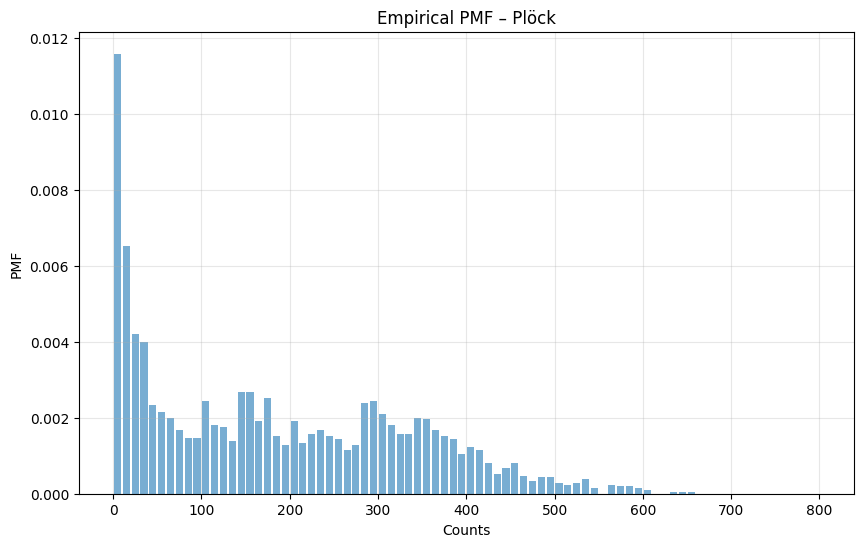

In [282]:
def plot_empirical_pmf(bins_mid, pmf, station_name, bin_width=10, fig_size=(10,6), y_max=None):
  plt.figure(figsize=fig_size)
  plt.bar(bins_mid, pmf, width=0.8 * bin_width, alpha=0.6)
  plt.xlabel("Counts")
  plt.ylabel("PMF")
  plt.title(f"Empirical PMF – {station_name}")
  plt.grid(True, alpha=0.3)
  
  if y_max is not None:
        plt.ylim(0, y_max)

  plt.show()
plot_empirical_pmf(bins_mid=bins_mid, pmf=pmf, station_name=station)

In [283]:
def plot_pmf_compare(values1, values2, label1, label2, bin_width=10, max_value=800, y_max=0.02, figsize=(12,6), station_name=station, title = f"PMF Comparison - {station}"):
  bins = np.arange(0, max_value + bin_width, bin_width)

  pmf1, edges = np.histogram(values1, bins=bins, density=True)
  pmf2, _     = np.histogram(values2, bins=bins, density=True)

  bins_mid = (edges[:-1] + edges[1:]) / 2

  plt.figure(figsize=figsize)

  plt.bar(bins_mid, pmf1, width=0.8*bin_width, alpha=0.5, label=label1)
  plt.bar(bins_mid, pmf2, width=0.8*bin_width, alpha=0.5, label=label2)

  plt.xlabel("Counts")
  plt.ylabel("PMF")
  plt.title(title)
  plt.ylim(0, y_max)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()

Lets try to identify leisure traffic. 

Assumption: Weekdays is mostly leisure traffic. 

Try calculating weekday summer vs winter PMF.

In [284]:
import polars as pl

def get_filtered_values(station_name, channel="channels_all", interval=None, weekday=True, hour_min=0, hour_max=24):
  df = dl.get_bicycle(station_name=station_name, interval=interval).df
  
  if weekday:
      df = df.filter(pl.col("datetime").dt.weekday() < 5)
  else:
      df = df.filter(pl.col("datetime").dt.weekday() >= 5)
      
  df = df.filter(
      (pl.col("datetime").dt.hour() >= hour_min) &
      (pl.col("datetime").dt.hour() < hour_max)
  )
  
  return df[channel]


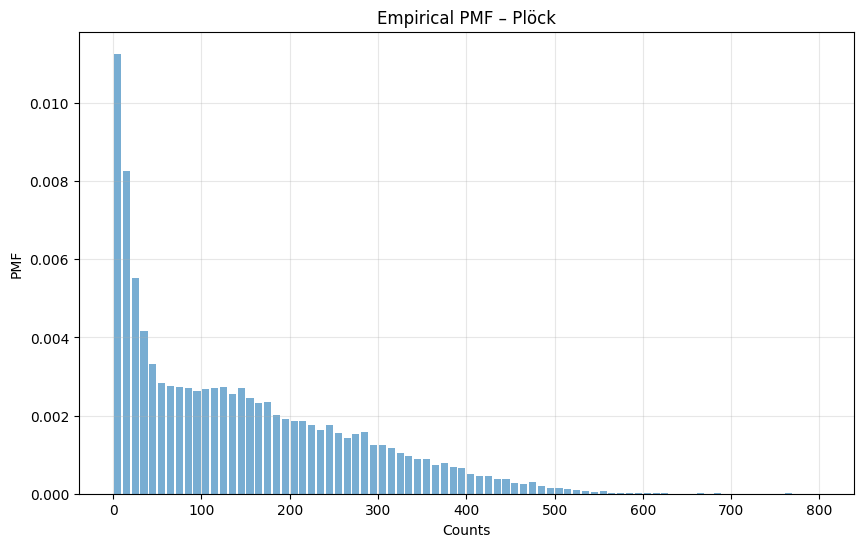

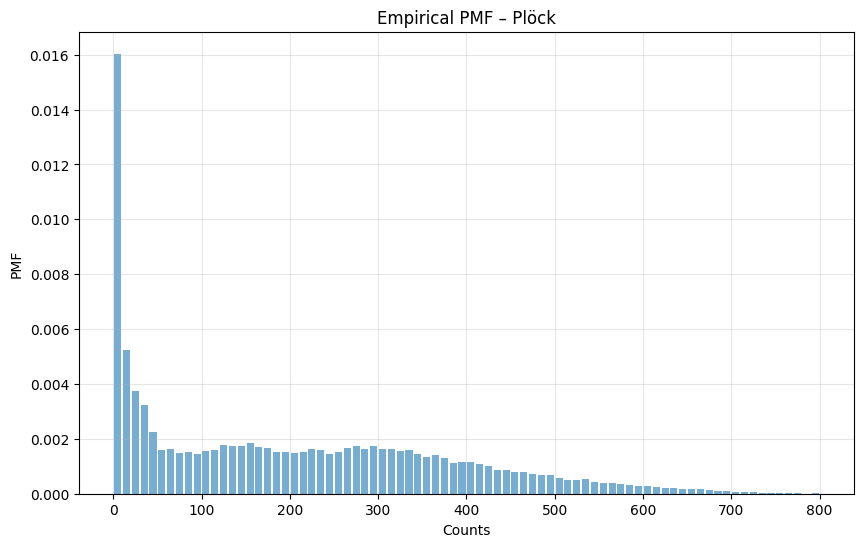

In [285]:
weekday_values = get_filtered_values(station_name=station, weekday=False)
weekend_values = get_filtered_values(station_name=station, weekday=True)

# summer weekday
bins_mid, pmf, counts, edges = calc_empirical_pmf(station, interval=interval_summer, values=weekday_values)
plot_empirical_pmf(bins_mid=bins_mid, pmf=pmf, station_name=station)

# summer weekend
bins_mid, pmf, counts, edges = calc_empirical_pmf(station, interval=interval_summer, values=weekend_values)
plot_empirical_pmf(bins_mid=bins_mid, pmf=pmf, station_name=station)

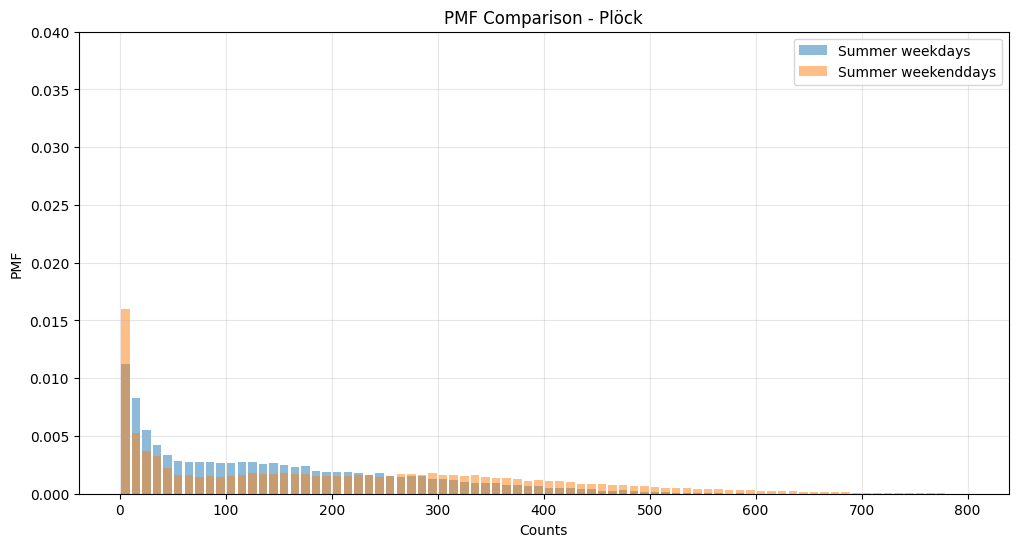

In [286]:
plot_pmf_compare(weekday_values, weekend_values, "Summer weekdays", "Summer weekenddays", y_max=0.04)

Maybe we should look at different time frames f.ex.:

- 06–10 
- 10–16 
- 16–19 
- 19–24 
- 00–06 

this could help us better identify work traffic.

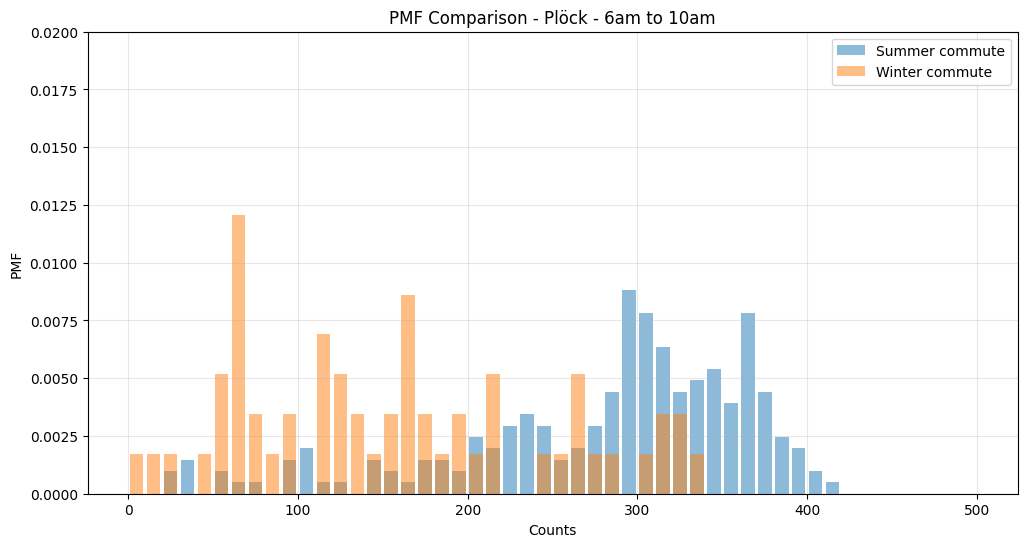

In [287]:
commute_summer = get_filtered_values(station, interval=interval_summer, weekday=True, hour_min=6, hour_max=10)
commute_winter = get_filtered_values(station, interval=interval_winter, weekday=True, hour_min=6, hour_max=10)

plot_pmf_compare(commute_summer, commute_winter, "Summer commute", "Winter commute", y_max=0.02, max_value=500, title=f"PMF Comparison - {station} - 6am to 10am")

it looks like that for station Plöck we can see two different distributions, indicating different behaviour for summer and winter months for commuting traffic.